In [1]:
import numpy as np
import scipy.special as sspec
import scipy.stats as ss
import multiprocessing as mp
import time

%matplotlib inline 
import matplotlib.pyplot as plt

In [2]:
def drift(x):
    return np.arctan(x)

def diff(x):
    return np.sqrt(1 + x**2)

In [3]:
def f(x,s,h):
    return np.exp(1j*s*h*drift(x) - h*np.abs(s)*diff(x)) 

In [4]:
# set up grids of s and u values
smin = -100
smax = 100
sres = 10000
ds = (smax-smin)/sres
svec = smin + ds*np.arange(sres)
uvec = np.copy(svec)

In [5]:
# set the value of h
thish = 0.01

# set the initial condition parameters
mymean = 0.5
mysd = 0.05

# set the initial pdf
def initp(x):
    return ss.norm.pdf(x,loc=mymean,scale=mysd)

# set the initial charfun
def initpcf(s):
    return np.exp(1j*mymean*s - 0.5*(mysd*s)**2)

In [5]:
# set up x grid for integration
Nx = 128
L = 12.8
dx = L/Nx
xvec = np.arange(-L/2,L/2,dx)

In [6]:
# initialize kernel matrix
# kernelmat = np.zeros((sres,sres),dtype='D')

In [8]:
def computeonerow(i):
    
    outrow = np.zeros(sres,dtype='D')
    s = svec[i]
    
    # handle special Dirac delta case
    if i==(sres//2):
        outrow[i] = 1.0/ds
        return outrow
    
    # handle "boundary layer" near Dirac delta
    # if np.abs(svec[i])<1.0:
    #     outrow[sres//2] = 1.0/ds
    #     outrow[(sres//2 + 1)] = s*0.5/(ds*ds)
    #     outrow[(sres//2 - 1)] = -s*0.5/(ds*ds)
    #     return outrow
    
    # compute shifted coordinate
    k = s - uvec
        
    # compute integral for all values of u
    for j in range(Nx):
        
        # compute quadrature points
        x1 = xvec[j]
        x2 = x1 + dx
        
        # product quadrature rule
        m0 = np.divide((np.exp(1j*k*x2) - np.exp(1j*k*x1)), 1j*k, 
                       out=dx*np.ones_like(k,dtype='D'), where=k!=0)
        m1 = np.divide((x2*np.exp(1j*k*x2) - x1*np.exp(1j*k*x1)), 1j*k, 
                       out=0.5*(x2**2 - x1**2)*np.ones_like(k,dtype='D'), where=k!=0)
        m1 += np.divide((np.exp(1j*k*x2) - np.exp(1j*k*x1)), k**2, 
                        out=np.zeros_like(k,dtype='D'), where=k!=0)
        
        # compute quadrature weights
        w1 = -(m1 - x2*m0)/dx
        w2 = (m1 - x1*m0)/dx
        
        # compute integral over [x1, x2]
        outrow += w1*f(x1,s,thish) + w2*f(x2,s,thish)
    
    # add asymptotic corrections
    outrow += 2.0*np.real((1j*np.exp((1j*(thish*np.pi*s + L*k + 1j*thish*L*np.abs(s)))/2.))/(k + 1j*thish*np.abs(s)))
    # outrow += (-1j*np.exp((-1j*(thish*np.pi*s + L*k - 1j*thish*L*np.abs(s)))/2.))/(k - 1j*thish*np.abs(s))
    outrow /= (2.0*np.pi)
    
    return outrow


In [9]:
curtime = time.time()
pool = mp.Pool(processes=24)
kernelmat = np.vstack(pool.map(computeonerow, range(sres)))
timetaken = time.time() - curtime
print(timetaken)
pool.close()


925.0236208438873


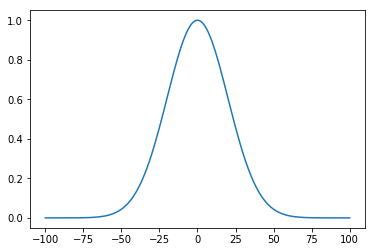

In [15]:
plt.plot(svec, np.abs(initpcf(svec)))

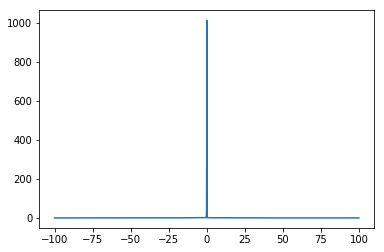

In [16]:
cf = (ds**2)*np.dot(kernelmat,np.dot(kernelmat, initpcf(svec)))
plt.plot(svec, np.abs(cf))

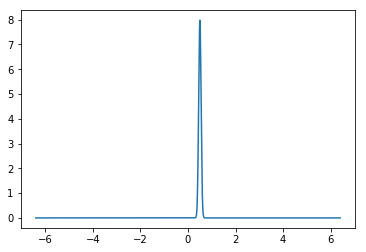

In [27]:
# set up x grid for plotting
Nxplot = 16384
Lplot = 12.8
dxplot = Lplot/Nxplot
xplot = np.arange(-Lplot/2,Lplot/2,dxplot)

# initial PDF
plt.plot(xplot, initp(xplot))

In [28]:
# Fourier matrix
fouriermat = np.zeros((Nxplot,sres),dtype='D')
for i in range(Nxplot):
    fouriermat[i,] = np.exp(-1j*uvec*xplot[i])/(2.0*np.pi)


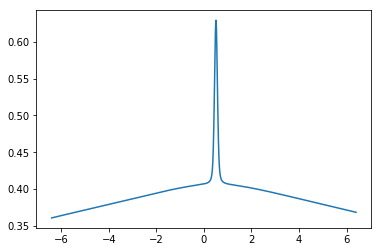

In [29]:
# PDF at next time step
plt.plot(xplot, np.real(dxplot*np.dot(fouriermat,cf)))

In [31]:
np.save(file='kernelmat1',arr=kernelmat)